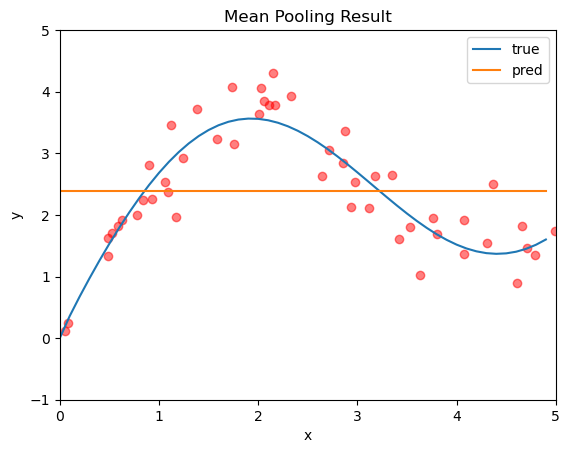

In [2]:
import torch, attension_visualization, utils
import matplotlib.pyplot as plt
from torch import nn

# 人工数据集 y[i] = 2*sin(x[i]) + x^(0.8) + theta, theta是噪声项,服从均值为0和标准差为0.5的正态分布
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 为了更好地可视化之后的注意力模式，需要将训练样本进行排序

def f(x):
    return 2*torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(mean = 0, std = 0.5, size = (n_train,)) # 训练样本的标签
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_test = f(x_test) # 测试样本的标签
n_test = len(x_test) # 测试样本数

def plot_kernel_regression(y_hat, title='None'):
    res = utils.ResVisualization(xlist=[x_test, x_test], ylist=[y_test, y_hat],
                                 xlabel='x', ylabel='y', legend_names=['true', 'pred'],
                                 xlim=[0,5], ylim=[-1,5], title=title)
    plt.plot(x_train, y_train,'ro', alpha=0.5)
    res.plot_res()

# 平均汇聚结果 即将所有训练样本标签的平均值作为预测值
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_regression(y_hat, title='Mean Pooling Result')

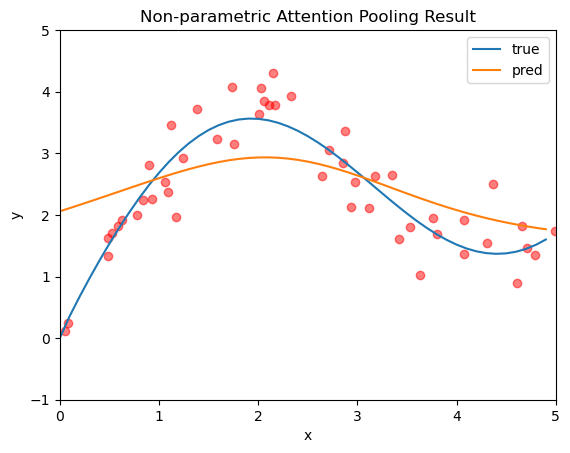

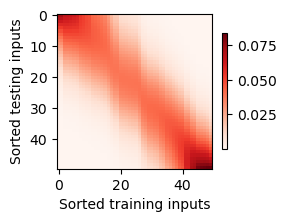

In [3]:
# 非参数注意力汇聚
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train)) # X_repeat的形状:(n_test,n_train), 每一行都包含着相同的测试输入（例如：同样的查询）
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)

#非参数注意力汇聚结果
plot_kernel_regression(y_hat, title='Non-parametric Attention Pooling Result')
attension_visualization.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                                      xlabel= 'Sorted training inputs', ylabel='Sorted testing inputs')
# 结果: "查询‐键"对 越接近，注意力汇聚的注意力权重就越高。

### 非参数注意力汇聚 
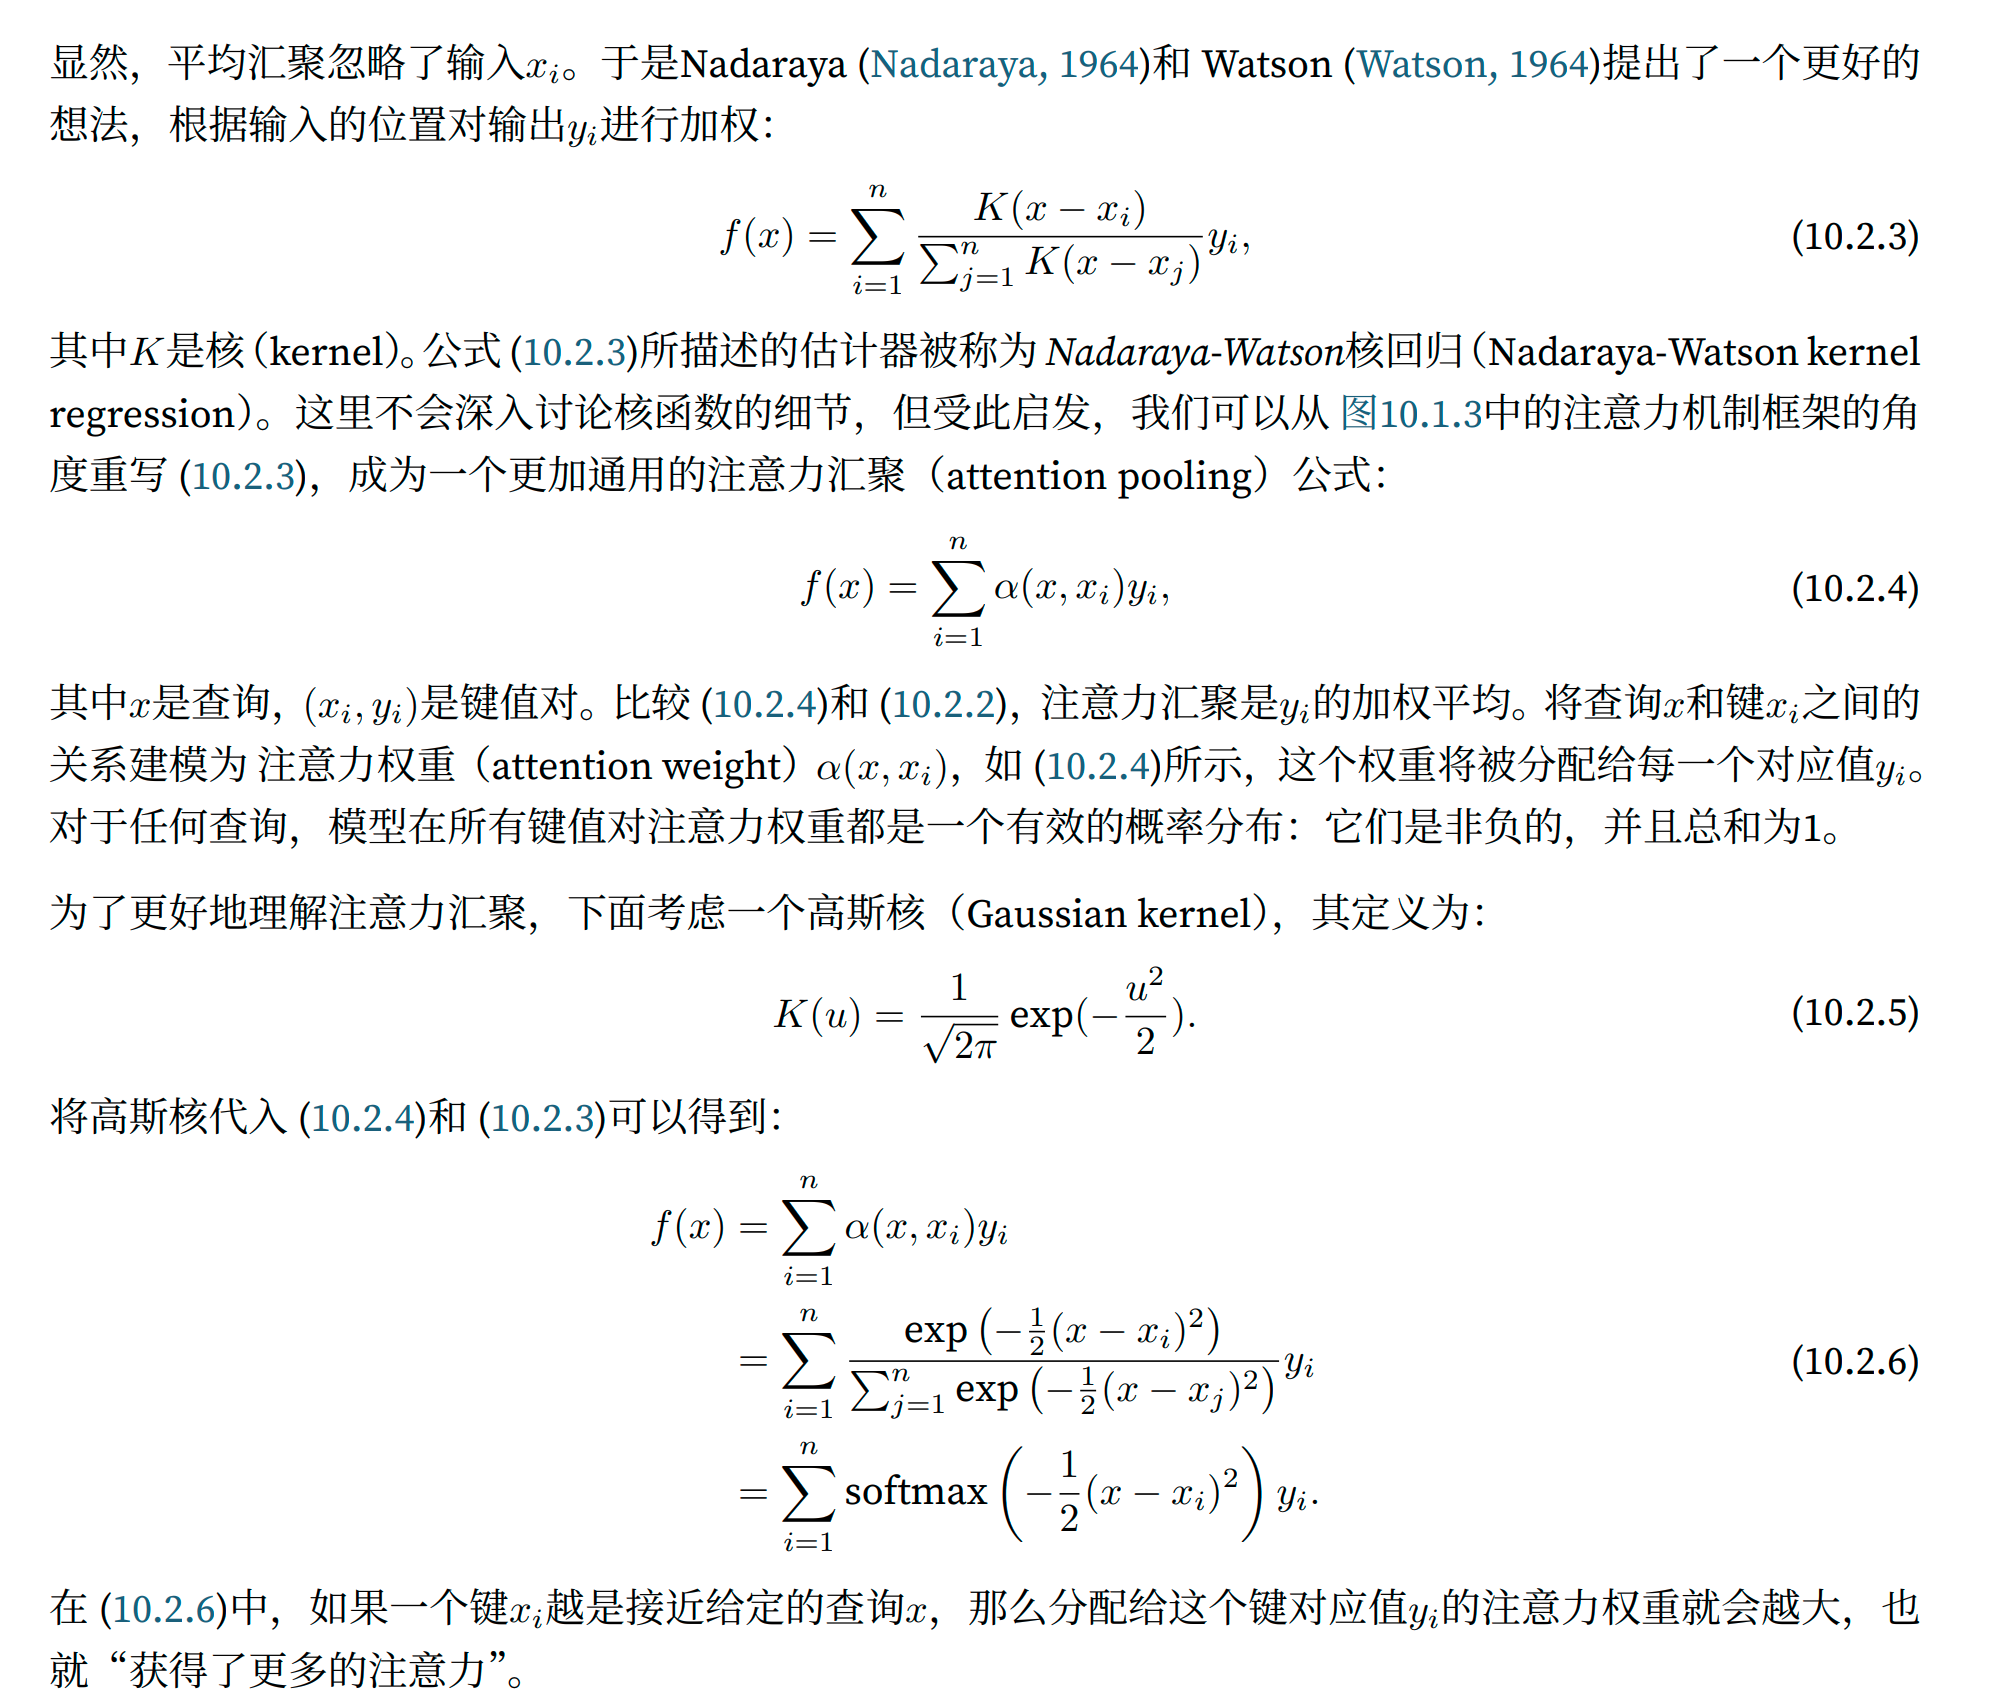

epoch 1, loss 32.107
epoch 2, loss 18.196
epoch 3, loss 18.192
epoch 4, loss 18.188
epoch 5, loss 18.184
epoch 6, loss 18.179
epoch 7, loss 18.175
epoch 8, loss 18.171
epoch 9, loss 18.166
epoch 10, loss 18.162
epoch 11, loss 18.157
epoch 12, loss 18.152
epoch 13, loss 18.148
epoch 14, loss 18.143
epoch 15, loss 18.138
epoch 16, loss 18.133
epoch 17, loss 18.127
epoch 18, loss 18.122
epoch 19, loss 18.117
epoch 20, loss 18.111


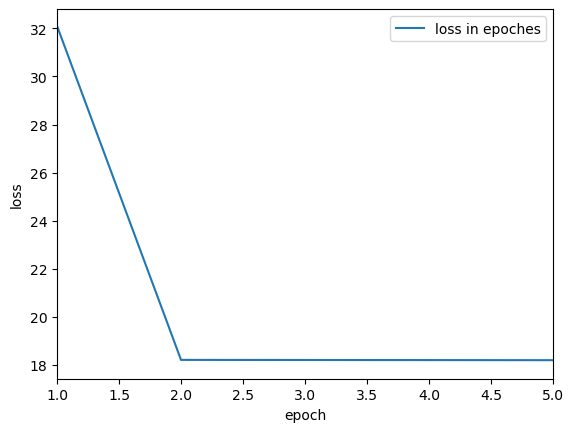

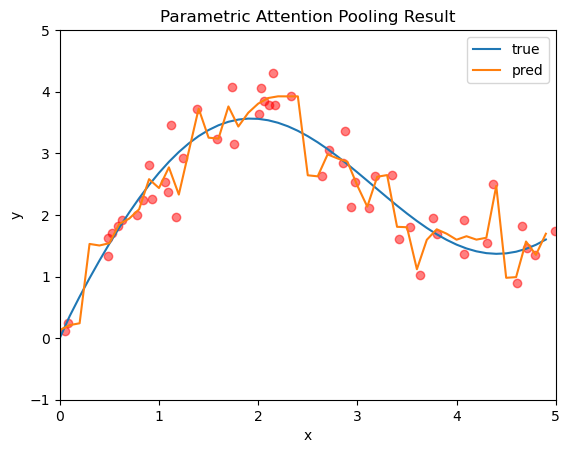

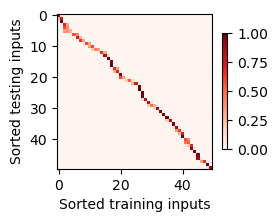

In [4]:
# 带参数注意力汇聚

# 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # values和attention_weights的形状为(查询个数, "键－值"对个数)
        # queries的形状为(查询个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries-keys)*self.w)**2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

# 训练
X_tile = x_train.repeat((n_train, 1)) # --> 形状:(n_train，n_train)，每一行都包含着相同的训练输入
Y_tile = y_train.repeat((n_train, 1)) # --> 形状:(n_train，n_train)，每一行都包含着相同的训练输出
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) # --> 形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1)) # --> 形状:('n_train'，'n_train'-1)

net = NWKernelRegression()
loss_function = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=1)
res = utils.ResVisualization(xlist=[[]], ylist=[[]], xlabel='epoch', ylabel='loss',
                             legend_names=['loss in epoches'], xlim=[1,5])
for epoch in range(20):
    trainer.zero_grad()
    loss = loss_function(net(x_train, keys, values), y_train)
    loss.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(loss.sum()):.3f}')
    res.add(epoch + 1, float(loss.sum()), 'loss in epoches')
res.plot_res()

# 预测
keys = x_train.repeat((n_test, 1)) # keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
values = y_train.repeat((n_test, 1)) # value的形状:(n_test，n_train)
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_regression(y_hat, title='Parametric Attention Pooling Result')
attension_visualization.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                                      xlabel= 'Sorted training inputs', ylabel='Sorted testing inputs')

### 带参数注意力汇聚
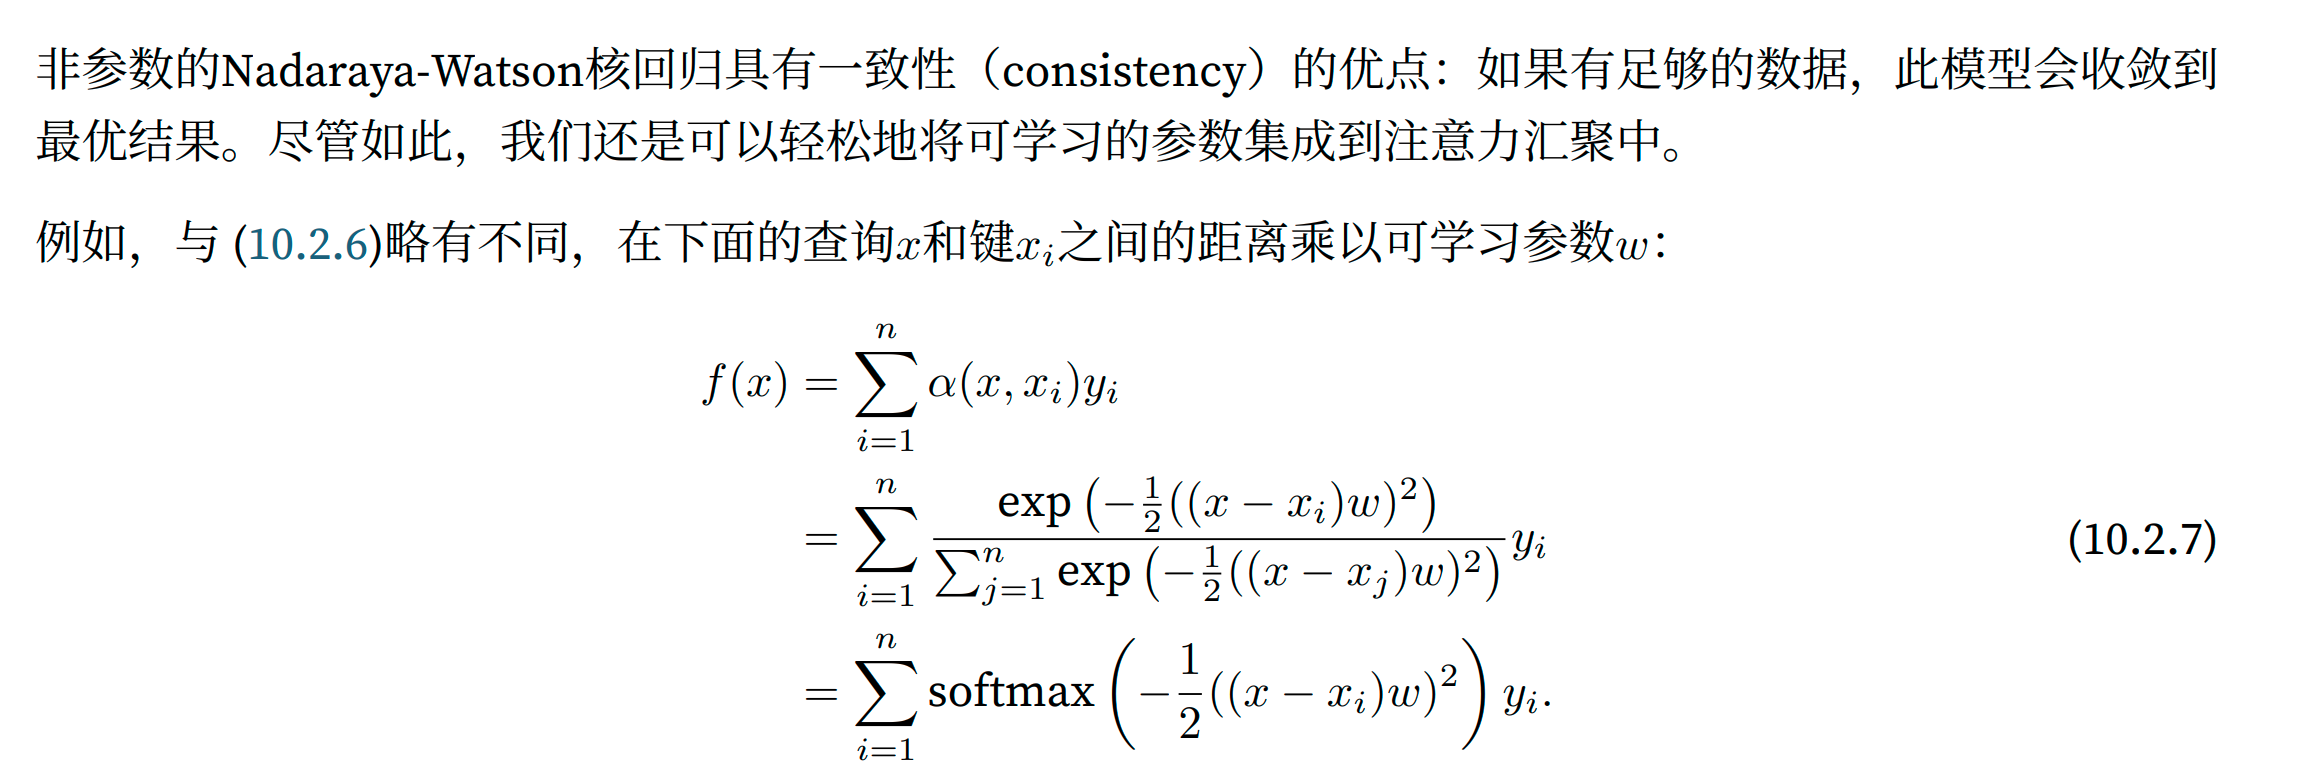